## Check the GPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
4.7617306740000345
GPU (s):
0.1160376240000005
GPU speedup over CPU: 41x


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Load the dataset

In [ ]:
from google.colab import files
# Upload your kaggle.json file with your username and your Kaggle API token.
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"djanyhelp","key":"0537a289538e99e34a50d5aea7cfeb91"}'}

In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json
# Next, install the Kaggle API client.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 65 Mar 10 08:46 kaggle.json


In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset --unzip -p /content/I2I

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [01:00<00:00, 24.4MB/s]
100% 1.33G/1.33G [01:00<00:00, 23.6MB/s]


# Build the dataset

In [ ]:
import os
dataset_dir = "/content/I2I"

def download_celabA(dataset_dir):
    """
    Downloads CelebA dataset from Kaggle and loads it in dataset_dir.
    """
    if not os.path.exists(dataset_dir):
        kaggle.api.authenticate()
        kaggle.api.dataset_download_files(dataset="jessicali9530/celeba-dataset", path=dataset_dir, unzip=True)
        print('Download completed.')
    else:
        print('CelebA dataset already exists.')

    return True


if __name__ == '__main__':

    download_celabA(dataset_dir)

CelebA dataset already exists.


In [ ]:
import sys
from collections import OrderedDict
import cv2
from tensorflow.keras.utils import Sequence
import math
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
import pickle  # Import pickle for saving test set data

class CelebADataset(Sequence):
    def __init__(self, train_size, batch_size, mode='train', save_test_set=False):
        self.dataset_dir = "/content/I2I"  # Updated directory
        self.train_img_ids, self.test_img_ids, self.attributes = self.load(train_size)
        self.batch_size = batch_size
        self.mode = mode
        self.train_size = len(self.train_img_ids)

        if save_test_set:
            self.save_test_set()  # Save test set data if required

    def load(self, train_dim):
        """Loads image IDs and attributes, then splits into train and test sets."""
        print("Loading images ID and attributes...", flush=True)

        file_path = os.path.join(self.dataset_dir, "list_attr_celeba.csv")  # Updated Path
        df = pd.read_csv(file_path, header=0, index_col=0).replace(-1, 0)
        attributes = [x for x in df.columns]
        od = OrderedDict(df.to_dict('index'))
        img_ids = OrderedDict()

        for k, v in od.items():
            img_id = [np.float32(x) for x in v.values()]
            img_ids[k] = img_id

        print(f"img_ids: {len(img_ids)} \nAttributes: {len(attributes)} \n", flush=True)

        # Splitting dataset
        print("Splitting dataset...\n", flush=True)
        n_train = int(len(img_ids) * train_dim)
        list_img_ids = list(img_ids.items())
        train_img_ids = list_img_ids[:n_train]
        test_img_ids = list_img_ids[n_train:]

        print(f"Train set dimension: {len(train_img_ids)} \nTest set dimension: {len(test_img_ids)} \n", flush=True)

        return train_img_ids, test_img_ids, attributes

    def save_test_set(self):
        """Saves test set image IDs and attributes to a pickle file."""
        test_set_data = {
            "test_img_ids": self.test_img_ids,
            "attributes": self.attributes
        }
        with open("test_set.pkl", "wb") as f:
            pickle.dump(test_set_data, f)
        print("Test set saved successfully.")

    def preprocess_image(self, image_path, img_size=128, img_resize=64, x=25, y=45):
        """Crops, resizes, and normalizes the image."""
        img = cv2.imread(image_path)
        img = img[y:y+img_size, x:x+img_size]
        img = cv2.resize(img, (img_resize, img_resize))
        img = np.array(img, dtype='float32')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img /= 255.0  # Normalize to [0,1]
        return img

    def get_images(self, imgs_id):
        """Fetch images corresponding to given IDs."""
        imgs = []
        for i in imgs_id:
            image_path = os.path.join(self.dataset_dir, "img_align_celeba", "img_align_celeba", i)  # Updated Path
            imgs.append(self.preprocess_image(image_path))
        return imgs

    def next_batch(self, idx):
        """Returns batch of images and their IDs."""
        print(f"Fetching batch {idx}...", flush=True)
        batch_img_ids = [x[1] for x in self.train_img_ids[idx * self.batch_size : (idx + 1) * self.batch_size]]
        images_id = [x[0] for x in self.train_img_ids[idx * self.batch_size : (idx + 1) * self.batch_size]]
        batch_imgs = self.get_images(images_id)
        return np.asarray(batch_imgs, dtype='float32'), np.asarray(batch_img_ids, dtype='float32')

    def shuffle(self):
        """Shuffles training IDs."""
        self.train_img_ids = random.sample(self.train_img_ids, k=self.train_size)
        print("IDs shuffled.", flush=True)

    def __len__(self):
        return int(math.ceil(self.train_size / float(self.batch_size)))

    def __getitem__(self, index):
        print(f"Getting item {index}...", flush=True)
        return self.next_batch(index)


In [ ]:
#  Training configuration
learning_rate = 0.001
train_size = 0.01
batch_size = 32
save_test_set = True # S# True: the test set image IDs and other useful information will be stored in a pickle file to further uses (e.g. Image_Generation.ipynb)


dataset = CelebADataset(train_size = train_size, batch_size = batch_size, save_test_set = save_test_set)

Loading images ID and attributes...
img_ids: 202599 
Attributes: 40 

Splitting dataset...

Train set dimension: 2025 
Test set dimension: 200574 

Test set saved successfully.


# Define the model

In [ ]:
# Hyper-parameters
label_dim = 4
image_dim = [64, 64, 3]
latent_dim = 256
beta = 0.75


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape

#########################
#        ENCODER        #
#########################

class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.enc_block_1 = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', kernel_initializer=he_normal())
        self.enc_block_2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', kernel_initializer=he_normal())
        self.enc_block_3 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', kernel_initializer=he_normal())
        self.enc_block_4 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same', kernel_initializer=he_normal())

        self.flatten = Flatten()
        self.dense = Dense(latent_dim * 2)  # Outputs mean & log variance

    def call(self, conditional_input, training=False):
        x = tf.nn.leaky_relu(BatchNormalization()(self.enc_block_1(conditional_input), training=training))
        x = tf.nn.leaky_relu(BatchNormalization()(self.enc_block_2(x), training=training))
        x = tf.nn.leaky_relu(BatchNormalization()(self.enc_block_3(x), training=training))
        x = tf.nn.leaky_relu(BatchNormalization()(self.enc_block_4(x), training=training))
        x = self.dense(self.flatten(x))
        return x


#########################
#        DECODER        #
#########################

class Decoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.dense = Dense(4 * 4 * 256)  # Using 256 filters at this stage
        self.reshape = Reshape(target_shape=(4, 4, 256))

        self.dec_block_1 = Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', kernel_initializer=he_normal())
        self.dec_block_2 = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', kernel_initializer=he_normal())
        self.dec_block_3 = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', kernel_initializer=he_normal())
        self.dec_block_4 = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', kernel_initializer=he_normal())
        self.dec_block_5 = Conv2DTranspose(3, kernel_size=3, strides=1, padding='same', kernel_initializer=he_normal(), activation='sigmoid')

    def call(self, z_cond, training=False):
        x = tf.nn.leaky_relu(self.dense(z_cond))
        x = self.reshape(x)
        x = tf.nn.leaky_relu(BatchNormalization()(self.dec_block_1(x), training=training))
        x = tf.nn.leaky_relu(BatchNormalization()(self.dec_block_2(x), training=training))
        x = tf.nn.leaky_relu(BatchNormalization()(self.dec_block_3(x), training=training))
        x = tf.nn.leaky_relu(BatchNormalization()(self.dec_block_4(x), training=training))
        return self.dec_block_5(x)


#########################
#       Conv-CVAE       #
#########################

class ConvCVAE(tf.keras.Model):
    def __init__(self, encoder, decoder, label_dim, latent_dim, beta=1.0, image_dim=(64, 64, 3)):
        super(ConvCVAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.label_dim = label_dim
        self.latent_dim = latent_dim
        self.beta = beta

        self.image_dim = image_dim

    def call(self, inputs, training=False):
        input_img, input_label, conditional_input = self.conditional_input(inputs)

        z_mean, z_log_var = tf.split(self.encoder(conditional_input, training=training), num_or_size_splits=2, axis=1)
        z_cond = self.reparametrization(z_mean, z_log_var, input_label)
        recon_img = self.decoder(z_cond, training=training)

        # Loss computation
        # latent_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        # reconstr_loss = tf.keras.losses.binary_crossentropy(input_img, recon_img)  # BCE without unnecessary scaling
        # loss = tf.reduce_mean(reconstr_loss + self.beta * latent_loss)


        # Latent loss (KL Divergence)
        latent_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        # Reconstruction loss (BCE)
        reconstr_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(input_img, recon_img))
        # Total loss (beta-VAE)
        loss = reconstr_loss + self.beta * latent_loss



        return {
            'recon_img': recon_img,
            'latent_loss': latent_loss,
            'reconstr_loss': reconstr_loss,
            'loss': loss,
            'z_mean': z_mean,
            'z_log_var': z_log_var
        }


    def conditional_input(self, inputs):
        """Builds the conditional input with labels concatenated as channels."""
        input_img = inputs[0]
        input_label = inputs[1]

        labels = tf.reshape(input_label, [-1, 1, 1, self.label_dim])  # Shape: (batch_size, 1, 1, label_size)
        labels = tf.ones([tf.shape(input_img)[0], self.image_dim[0], self.image_dim[1], self.label_dim]) * labels
        conditional_input = tf.concat([input_img, labels], axis=-1)  # Concatenate along channel axis

        return input_img, input_label, conditional_input

    def reparametrization(self, z_mean, z_log_var, input_label):
        """Reparameterization trick to sample latent variable."""
        eps = tf.random.normal(shape=(tf.shape(input_label)[0], self.latent_dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * eps
        return tf.concat([z, input_label], axis=1)  # Concatenate latent vector with label


In [ ]:
# Initialize encoder and decoder
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim=latent_dim)


# Initialize model
model = ConvCVAE(
    encoder=encoder,
    decoder=decoder,
    label_dim=label_dim,
    latent_dim=latent_dim,
    beta=beta,
    image_dim=image_dim
)

# Define optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=5000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)



# Checkpoint

In [ ]:
import os

# Checkpoint path
checkpoint_root = "./CVAE{}_{}_checkpoint".format(latent_dim, beta)
checkpoint_name = "model"
save_prefix = os.path.join(checkpoint_root, checkpoint_name)

# Define the checkpoint
checkpoint = tf.train.Checkpoint(module=model)


In [ ]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_root)

if latest is not None:
    checkpoint.restore(latest)
    print("Checkpoint restored:", latest)
else:
  print("No checkpoint!") # If this is the first time you're running the model, there won't be any saved checkpoints to restore.

No checkpoint!


# Training & Testing

Train Step Function

In [ ]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os
import pickle
import tensorflow as tf
import time

#######################
# Train Step Function #
#######################

def train_step(data, model, optimizer):
    with tf.GradientTape() as tape:
        model_output = model(data)

    trainable_variables = model.trainable_variables
    grads = tape.gradient(model_output['loss'], trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))

    total_loss = model_output['loss'].numpy().mean()
    recon_loss = model_output['reconstr_loss'].numpy().mean()
    latent_loss = model_output['latent_loss'].numpy().mean()

    return total_loss, recon_loss, latent_loss

##################################
# Encoding and Decoding methods  #
##################################

def encode(self, inputs, label):
    return self.sess.run(self.z_mean, feed_dict={self.x: inputs, self.y: label})

def decode(self, label, z=None):
    if z is None:
        z = 0.0 + np.random.randn(self.batch_size, self.latent_dim) * 0.75
    return self.sess.run(self.generated_image, feed_dict={self.z_sample_3: z, self.y: label})

########################
#  Utils for plotting  #
########################

def batch_generator(batch_dim, test_labels, model_name):
    while True:
        batch_imgs, labels = [], []
        for label in test_labels:
            labels.append(label)
            if len(labels) == batch_dim:
                batch_imgs = create_image_batch(labels, model_name)
                batch_labels = [x[1] for x in labels]
                yield np.asarray(batch_imgs), np.asarray(batch_labels)
                batch_imgs, labels, batch_labels = [], [], []
        if batch_imgs:
            yield np.asarray(batch_imgs), np.asarray(batch_labels)

def get_image(image_path, model_name, img_size=128, img_resize=64, x=25, y=45):
    img = cv2.imread(image_path)
    img = img[y:y+img_size, x:x+img_size]
    img = cv2.resize(img, (img_resize, img_resize))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
    return img.ravel() if model_name == "Dense" else img

def create_image_batch(labels, model_name):
    return [get_image('/content/I2I/img_align_celeba/img_align_celeba/' + item[0], model_name) for item in labels]

def convert_batch_to_image_grid(image_batch, dim=64):
    return (image_batch.reshape(4, 8, dim, dim, 3)
            .transpose(0, 2, 1, 3, 4)
            .reshape(4 * dim, 8 * dim, 3))

def imshow_grid(imgs, model_name, shape=[2, 5], name='default', save=False):
    fig = plt.figure(1)
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)
    for i in range(shape[0] * shape[1]):
        grid[i].axis('off')
        grid[i].imshow(imgs[i].reshape(64, 64, 3) if model_name == "Dense" else imgs[i])
    if save:
        plt.savefig(str(name) + '.png')
        plt.clf()
    else:
        plt.show()


#   Utils to save and read pickle files

def save_data(file_name, data):
    with open(file_name + '.pickle', 'wb') as openfile:
        pickle.dump(data, openfile)

def read_data(file_name):
    with open(file_name + '.pickle', "rb") as openfile:
        return pickle.load(openfile)

Training Loop with Accuracy Log

In [ ]:
train_losses, train_recon_errors, train_latent_losses = [], [], []
loss, reconstruct_loss, latent_loss = [], [], []
n_epochs, step_index = 30, 0
n_batches = int(dataset.train_size / batch_size)

print("Number of epochs: {},  number of batches: {}".format(n_epochs, n_batches))

for epoch in range(50):
    start_time = time.perf_counter()
    dataset.shuffle()

    for step_index, inputs in enumerate(dataset):
        total_loss, recon_loss, lat_loss = train_step(inputs, model, optimizer)
        train_losses.append(total_loss)
        train_recon_errors.append(recon_loss)
        train_latent_losses.append(lat_loss)

        if step_index + 1 == n_batches:
            break

    loss.append(np.mean(train_losses, 0))
    reconstruct_loss.append(np.mean(train_recon_errors, 0))
    latent_loss.append(np.mean(train_latent_losses, 0))

    exec_time = time.perf_counter() - start_time
    print("Execution time: %0.3f \t Epoch %i: loss %0.4f | reconstr loss %0.4f | latent loss %0.4f"
          % (exec_time, epoch, loss[epoch], reconstruct_loss[epoch], latent_loss[epoch]))

    if (epoch + 1) % 5 == 0:
        checkpoint.save(save_prefix + "_" + str(epoch + 1))
        print("Model saved:", save_prefix)

checkpoint.save(save_prefix)
print("Model saved:", save_prefix)

Streaming output truncated to the last 5000 lines.
Getting item 0...
Fetching batch 0...
Getting item 1...
Fetching batch 1...
Getting item 2...
Fetching batch 2...
Getting item 3...
Fetching batch 3...
Getting item 4...
Fetching batch 4...
Getting item 5...
Fetching batch 5...
Getting item 6...
Fetching batch 6...
Getting item 7...
Fetching batch 7...
Getting item 8...
Fetching batch 8...
Getting item 9...
Fetching batch 9...
Getting item 10...
Fetching batch 10...
Getting item 11...
Fetching batch 11...
Getting item 12...
Fetching batch 12...
Getting item 13...
Fetching batch 13...
Getting item 14...
Fetching batch 14...
Getting item 15...
Fetching batch 15...
Getting item 16...
Fetching batch 16...
Getting item 17...
Fetching batch 17...
Getting item 18...
Fetching batch 18...
Getting item 19...
Fetching batch 19...
Getting item 20...
Fetching batch 20...
Getting item 21...
Fetching batch 21...
Getting item 22...
Fetching batch 22...
Getting item 23...
Fetching batch 23...
Getting i

In [ ]:
from google.colab import drive
import os

# Define the directory in Google Drive
save_dir = "/content/drive/MyDrive/Colab Notebooks/FYP/checkpoints"
os.makedirs(save_dir, exist_ok=True)

# Save checkpoint in Google Drive
checkpoint_path = os.path.join(save_dir, save_prefix)
checkpoint.save(checkpoint_path)
print("Model saved at:", checkpoint_path)

Model saved at: /content/drive/MyDrive/Colab Notebooks/FYP/checkpoints/./CVAE256_0.75_checkpoint/model


# Loss Visualization

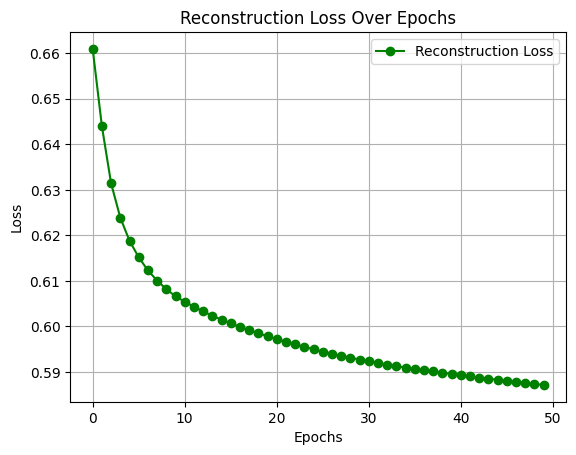

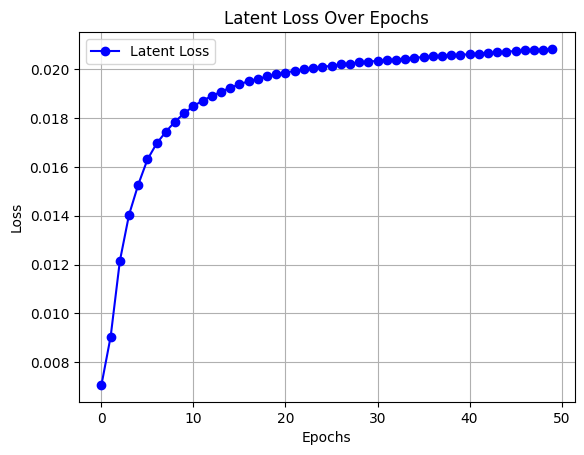

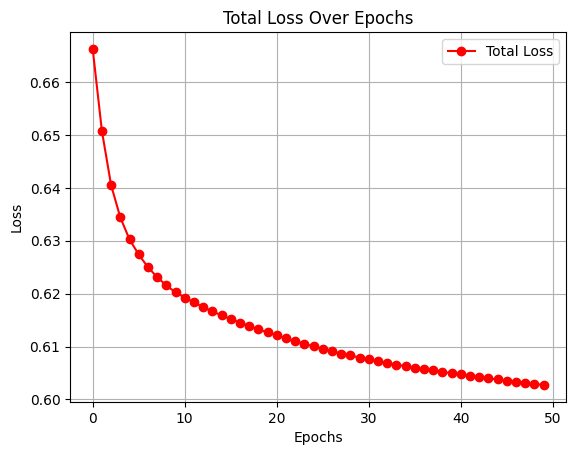

In [ ]:
import matplotlib.pyplot as plt

# Plot Reconstruction Loss
plt.plot(reconstruct_loss, 'g', marker='o', label='Reconstruction Loss')
plt.title('Reconstruction Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

# Plot Latent Loss
plt.plot(latent_loss, 'b', marker='o', label='Latent Loss')
plt.title('Latent Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

# Plot Total Loss
plt.plot(loss, 'r', marker='o', label='Total Loss')
plt.title('Total Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
